<a href="https://colab.research.google.com/github/sujitojha1/ERA1/blob/main/Session7/ERA1_S7_step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Models

In [10]:
!pip install torchsummary
!git clone https://github.com/sujitojha1/ERA1 -q --quiet
!mv ERA1/Session7/*.py .
!rm -rf ERA1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 3
### Target
1. Include StepLR rate schedule
2. Optimize the learning rate and drop out value


In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [12]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [13]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model

In [15]:
from model import *
Net = Model_3

## Model Params

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,152
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
          Dropout-12           [-1, 16, 10, 10]               0

## Training and Testing

In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06738864630460739 Batch_id=468 Accuracy=92.41: 100%|██████████| 469/469 [00:28<00:00, 16.45it/s]



Test set: Average loss: 0.0504, Accuracy: 9864/10000 (98.64%)

EPOCH: 1


Loss=0.03313547745347023 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]



Test set: Average loss: 0.0365, Accuracy: 9883/10000 (98.83%)

EPOCH: 2


Loss=0.11904186755418777 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]



Test set: Average loss: 0.0354, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.04955326393246651 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]



Test set: Average loss: 0.0323, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.08115693181753159 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0285, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.07075100392103195 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0279, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.02465773932635784 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]



Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.006316815037280321 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]



Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.05007535591721535 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]



Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.04443604126572609 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]



Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.03899465128779411 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.042780373245477676 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]



Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.011945092119276524 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.014276173897087574 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:23<00:00, 20.10it/s]



Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.004822971299290657 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:23<00:00, 19.97it/s]



Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

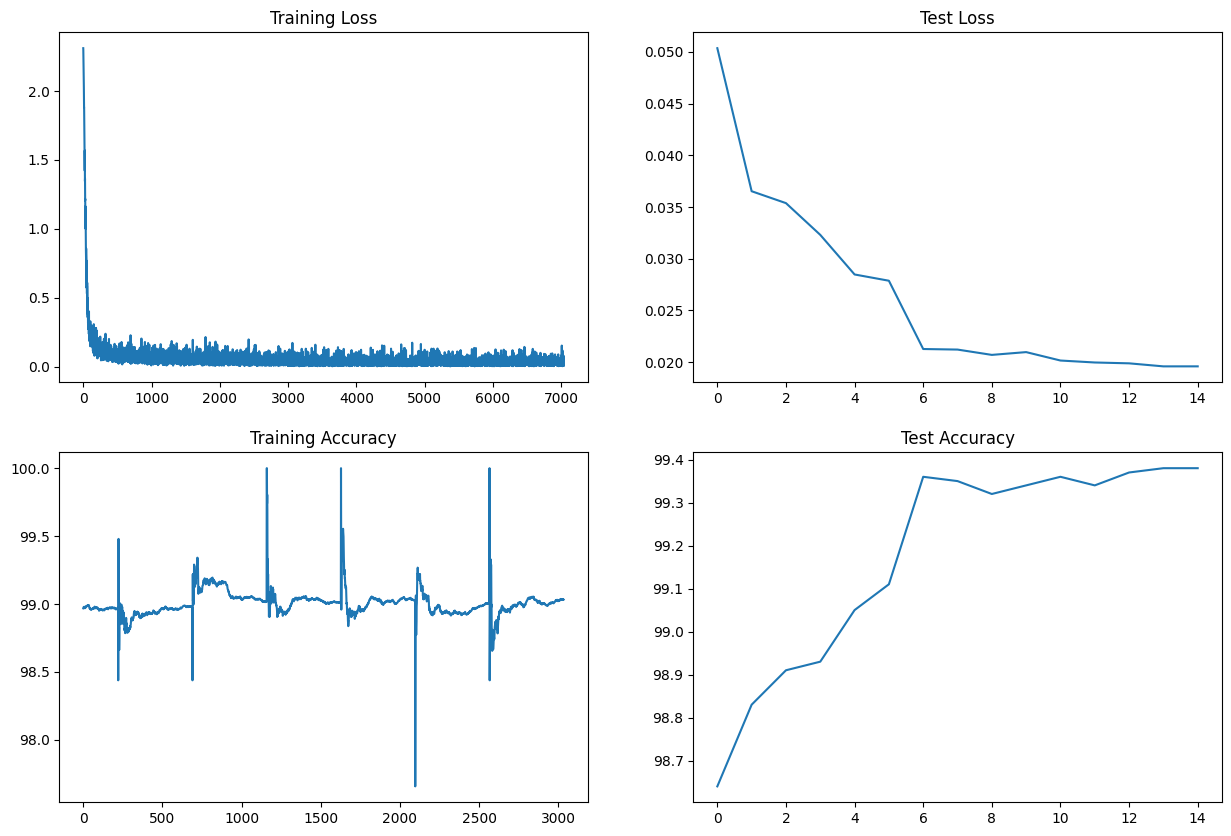

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")